# Image processing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

# import skimage
import skimage.io as io
from skimage.transform import resize, rescale
from scipy import ndimage

%matplotlib inline
from ipywidgets import interact, fixed

In [2]:
IMDIR = "./Images" # "./Replace/With/Your/Filepath"
# imagename = "einstein.jpg"
# filename = os.path.join(IMDIR, imagename)

# im = io.imread(filename, as_gray=True)
           
# The following lines control how big the images are shown on the screen
width = 15
height = 5
plt.rcParams['figure.figsize'] = [width, height]

Read and display the images in the provided folder

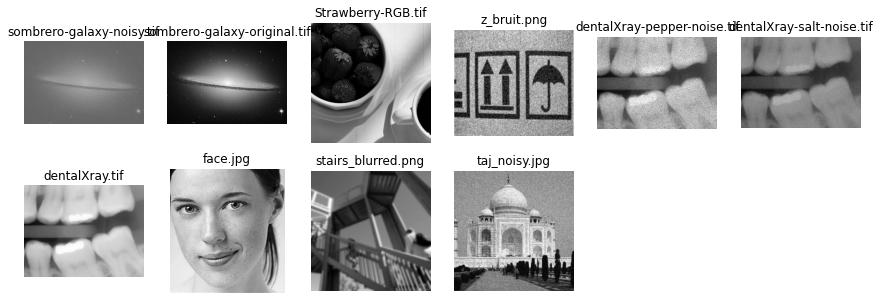

In [3]:
#  create a figure
fig = plt.figure()

# look for all available image files in IMDIR
im_counter = 1
for root, dirnames, filenames in os.walk(IMDIR):
    for filename in filenames:
        f = os.path.join(root, filename)
        
        #filter only image files with the following format
        if f.endswith(('.png', '.jpg', '.jpeg','.JPG', '.tif', '.gif')):

            im = io.imread(f,as_gray=True)
            
            if im_counter > 12: #showing maximum 25 images
                break
                
            # display it
            plt.subplot(2,6,im_counter)
            plt.imshow(im, cmap='gray')
            plt.title(filename)
            plt.axis('off')
            im_counter +=1 
            
plt.show()

## 0 General properties

In [4]:
SUBDIR = os.path.join(IMDIR, "general")

Luminance

In [5]:
# Compute the luminance of an image
def luminance(im):
    if len(im.shape) == 2: # if grayscale, values in range(0,1)
        h, w = im.shape
        luminance = np.sum(im)/(h*w)
        return luminance
    
    elif len(im.shape) == 3: # if RGB, values in range(0,255)
        h, w, _ = im.shape
        R = im[:,:,0]
        G = im[:,:,1]
        B = im[:,:,2]
            
        luminance = (0.299*np.sum(R) + 0.587*np.sum(G) + 0.114*np.sum(B)) /(h*w)
        return luminance
    
    else:
        raise ValueError('It is not a supported image format')

Contrast

In [6]:
# compute the contrast of an image
def contrast(im):
    if len(im.shape) == 2: # if grayscale
        h, w = im.shape
    elif len(im.shape) == 3: # if RGB
        h, w, _ = im.shape
    else:
        raise ValueError('It is not a supported image format')
    
    # contrast = (np.max(im)-np.min(im))/(np.max(im)+np.min(im))
    contrast = np.sqrt((1/(h*w) * np.sum((im-luminance(im))**2)))
    return contrast

Histogram and cummulative histogram

In [7]:
def histo(im, bins=255):
    hist, bin_edges = np.histogram(im, bins)
    bin_values = (bin_edges[:-1] + bin_edges[1:]) / 2
    cum_hist = np.cumsum(hist)
    
    plt.subplot(121)
    plt.plot(bin_values, hist)
    plt.title('Histogram')
    plt.subplot(122)
    plt.plot(bin_values, cum_hist)
    plt.title('Cummulative histogram')
    plt.show()

    return hist, cum_hist, bin_values

PSNR: Peak SNR

Typical values for the PSNR in lossy image are between 30 and 50 dB, where higher is better.

In [8]:
def psnr(im_ori, im_noise):
    if im_ori.shape != im_noise.shape:
        raise ValueError('Two images do not match')
    
    if len(im_ori.shape) == 2: # if grayscale
        h, w = im_ori.shape

    elif len(im_ori.shape) == 3: # if RGB
        h, w, _ = im_ori.shape
    else:
        raise ValueError('It is not a supported image format')
    
    mse = np.sum((im_ori - im_noise)**2)/(h*w) # mean square error
    psnr = 20*np.log10(im_ori.max()) - 10*np.log10(mse)
    return psnr

Test of functions

In [9]:
imagename = "Strawberry-RGB.tif"
filename = os.path.join(SUBDIR, imagename)
im = io.imread(filename, as_gray=True)
im = im/np.max(im) # normalize value range to 0~1

# plt.imshow(im, cmap='gray')
# plt.show()

# print(luminance(im))
# print(contrast(im))
# _, _, _ = histo(im)

# PSNR GALAXY
imagename = "sombrero-galaxy-original.tif"
filename = os.path.join(SUBDIR, imagename)
im_origi = io.imread(filename, as_gray=True)

imagename = "sombrero-galaxy-noisy.tif"
filename = os.path.join(SUBDIR, imagename)
im_noisy = io.imread(filename, as_gray=True)

print('psnr = ', psnr(im_origi, im_noisy))


psnr =  27.666217440866628


## 1 Intensity Transformations

In [10]:
def color2gray(im):
    return np.dot(im[...,0:3], [0.2989, 0.5870, 0.1140])

def gray2threshold(im, k):
    im_threshold = np.where(im < k, 0, 1)
    return im_threshold

def linear(im, a=4, b=0):
    return a*im + b

def invert(im):
    return im.max() + im.min() - im

def gamma(im, c=1, gamma=0.5):
    return c*im**gamma

def logtf(im):
    c = 255 / np.log(1 + im.max())
    return c * np.log(im + 1)

# we can also import them directly
# skimage.color.rgb2gray(im)
# skimage.exposure.adjust_gamma(image[, ...])
# skimage.exposure.adjust_log(image[, gain, inv])
# skimage.exposure.equalize_hist(img)

Test function

In [11]:
imagename = "Strawberry-RGB.tif"
filename = os.path.join(SUBDIR, imagename)
im = io.imread(filename, as_gray=True)
im = im/np.max(im) # normalize value range to 0~1


@interact(k = (0, 1, 0.01))
def show_threshold(k):
    plt.imshow(gray2threshold(im, k), cmap='gray')
    plt.show()
    return

interactive(children=(FloatSlider(value=0.0, description='k', max=1.0, step=0.01), Output()), _dom_classes=('w…

## 2 Morphological Operations

* For binary images, it is obvious because 0 is none(black) and 1 is present(white).
* For grayscale images, the erision/dilation of a pixel is defined by the smallest/largest grayscale contained in the structuring element.\
[Demostration of erosion](https://en.wikipedia.org/wiki/Erosion_(morphology)#/media/File:Grayscale_Morphological_Erosion.gif), 
[Demostration of dilation](https://en.wikipedia.org/wiki/Dilation_(morphology)#/media/File:Grayscale_Morphological_Dilation.gif)

In [12]:
from skimage.morphology import erosion, dilation, opening, closing
from skimage.morphology import disk, square, diamond, star

# creat different structuring elements
selem_disk = disk(5) # radius
selem_sq = square(8)
selem_diam = diamond(4)
selem_star = star(3)

Interactive way

In [13]:
imagename = "z_bruit.png"
filename = os.path.join(SUBDIR, imagename)
im = io.imread(filename, as_gray=True)
im = im/np.max(im) # normalize value range to 0~1

operation_map = {
    'erosion': erosion,
    'dilation': dilation,
    'opening': opening,
    'closing': closing,
    }

struc_elem_map = {
    'disk': disk,
    'square': square,
    'diamond': diamond,
    'star': star,
    }

def morphology(im, operation_name, struc_elem, r=5):
    if operation_name == 'original':
        plt.imshow(im, cmap='gray')
    else:
        selem = struc_elem_map[struc_elem](r)
        im = operation_map[operation_name](im, selem)
        plt.imshow(im, cmap='gray')
    plt.show()
    return

interact(
    morphology, 
    im = fixed(im),
    operation_name = ['original','erosion','dilation','opening','closing'], 
    struc_elem = ['disk','square','diamond','star'], 
    r=(0,10,1)
    )

interactive(children=(Dropdown(description='operation_name', options=('original', 'erosion', 'dilation', 'open…

<function __main__.morphology(im, operation_name, struc_elem, r=5)>

Basic comparision

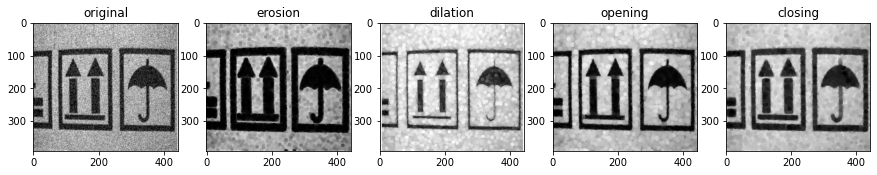

In [14]:
imagename = "z_bruit.png"
filename = os.path.join(SUBDIR, imagename)
im = io.imread(filename, as_gray=True)
im = im/np.max(im) # normalize value range to 0~1

im_counter = 1

plt.subplot(1,5,im_counter)
plt.imshow(im, cmap='gray')
plt.title('original')
im_counter +=1 

# erosion
eroded_im = erosion(im, selem_disk)
plt.subplot(1,5,im_counter)
plt.imshow(eroded_im, cmap='gray')
plt.title('erosion')
im_counter +=1 

# dilation
dilated_im = dilation(im, selem_disk)
plt.subplot(1,5,im_counter)
plt.imshow(dilated_im, cmap='gray')
plt.title('dilation')
im_counter +=1 

# opening
opened_im = opening(im, selem_disk)
plt.subplot(1,5,im_counter)
plt.imshow(opened_im, cmap='gray')
plt.title('opening')
im_counter +=1 

# closing
closed_im = closing(im, selem_disk)
plt.subplot(1,5,im_counter)
plt.imshow(closed_im, cmap='gray')
plt.title('closing')
im_counter +=1 

## 3 Spatial filtering

In [15]:
SUBDIR = os.path.join(IMDIR, "spatial_filter")

Kernal

In [16]:
def meanKernel(hs):
    kernel = np.zeros((hs*2+1,hs*2+1))
    kernel += 1/(hs*2+1)**2
    return kernel

def gaussianKernel(hs,sigma=1):
    u = hs*2+1
    v = hs*2+1
    kernel = np.zeros((u,v))
    for i in np.arange(u):
        for j in np.arange(v):
            kernel[i,j] = 1/(2*np.pi*sigma**2)*np.exp(-((i-hs)**2+(j-hs)**2)/(2*sigma**2))
    kernel = kernel/np.sum(kernel) # make sure sum=1 when discret
    return kernel

def xGradientkernel():
    kernel = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    return kernel
def yGradientkernel():
    kernel = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    return kernel
def laplaciankernel():
    kernel = np.array([[1,1,1],[1,-8,1],[1,1,1]])
    # kernel = np.array([[0,1,0],[1,-4,1],[0,1,0]])
    return kernel

Test convolution with Kernel

In [17]:
imagename = "face.jpg"
filename = os.path.join(SUBDIR, imagename)
im = io.imread(filename, as_gray=True)
im = im/np.max(im) # normalize value range to 0~1

kernel_map = {
    'mean': meanKernel,
    'gaussian': gaussianKernel,
    'x_gradient': xGradientkernel,
    'y_gradient': yGradientkernel,
    'laplacian': laplaciankernel,
    }

def spatial_filter(im, kernel_name, hs=3, sigma=1):
    if kernel_name == 'original':
        plt.imshow(im, cmap='gray')
        plt.show()
        return
    
    if kernel_name == 'mean':
        kernel = kernel_map[kernel_name](hs)
    elif kernel_name == 'gaussian':
        kernel = kernel_map[kernel_name](hs,sigma)
    else:
        try:
            kernel = kernel_map[kernel_name]()
        except KeyError:
            raise ValueError('Invalid kernal choice')

    im_filtered = ndimage.convolve(im, kernel)
    plt.imshow(im_filtered, cmap='gray')
    plt.show()
    return im_filtered

interact(
    spatial_filter, 
    im = fixed(im),
    kernel_name = ['original','mean','gaussian','x_gradient','y_gradient','laplacian'],
    hs = (0,8,1),
    sigma = (1e-10,3,0.01),
    )

interactive(children=(Dropdown(description='kernel_name', options=('original', 'mean', 'gaussian', 'x_gradient…

<function __main__.spatial_filter(im, kernel_name, hs=3, sigma=1)>

Image enhancement

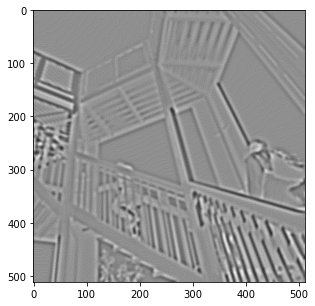

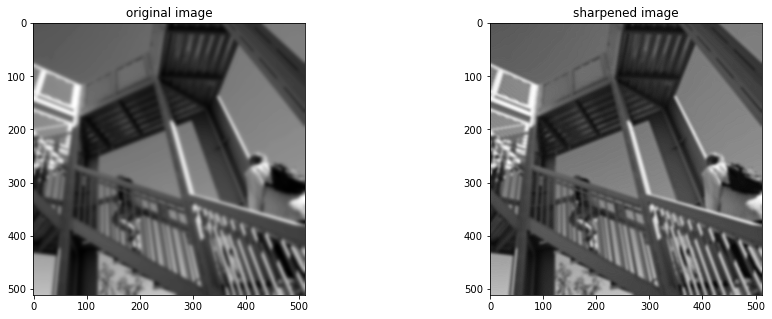

In [18]:
imagename = "stairs_blurred.png"
filename = os.path.join(SUBDIR, imagename)
im = io.imread(filename, as_gray=True)
im = im/np.max(im) # normalize value range to 0~1

c = -1 # depends on the central pixel of kernel, if positive then c=1
im_laplacian = spatial_filter(im, 'laplacian')
im_sharp = im + c*im_laplacian
im_sharp = im_sharp / np.max(im_sharp)

plt.subplot(121)
plt.imshow(im, cmap='gray')
plt.title('original image')
plt.subplot(122)
plt.imshow(im_sharp, cmap='gray')
plt.title('sharpened image')
plt.show()

Denoising

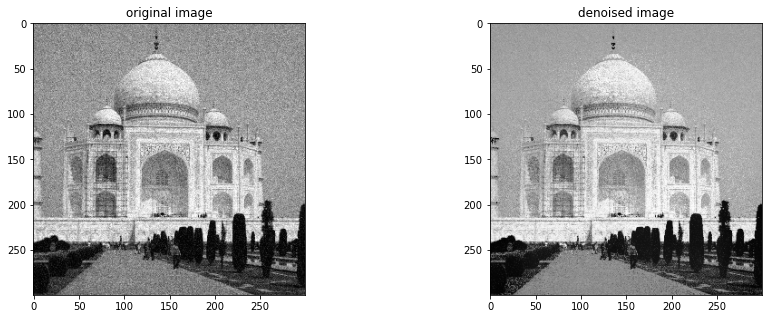

In [22]:
from skimage.restoration import denoise_bilateral

imagename = "taj_noisy.jpg"
filename = os.path.join(SUBDIR, imagename)
im = io.imread(filename, as_gray=True)
im = im/np.max(im) # normalize value range to 0~1

plt.subplot(121)
plt.imshow(im, cmap='gray')
plt.title('original image')

plt.subplot(122)
plt.imshow(denoise_bilateral(im, sigma_color=0.1, sigma_spatial=15), cmap='gray')
plt.title('denoised image')
plt.show()

## 4 Frequency analyse